In [47]:
# import necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, KFold
from sklearn.linear_model import LinearRegression, Ridge
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [48]:
# Covid-19 SG dataset details

sheet_id = "1gFTNs_GtnTIyyVWXmsQxwdZpGbyicZM2HJcXvCf4b3k"
sheet_name = "Sheet1"
url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"

In [49]:
# read Covid-19 SG dataset

sg_data = pd.read_csv(url)

In [50]:
# filter to include only columns A to AD

sg_data_filtered = sg_data.iloc[:, :30]

# EDA & Pre-processing

**Outliers will not be removed because of their importance in the Covid context.**

**No need for scaling as all features are of the same magnitude.**

**Can look into what other features can be included from the current ones through extrapolation.**

In [51]:
sg_data_filtered.head()

,Date,Daily Confirmed,False Positives Found,Cumulative Confirmed,Daily Discharged,Passed but not due to COVID,Cumulative Discharged,Discharged to Isolation,Still Hospitalised,Daily Deaths,...,Total Hospital Discharged MOH report,Requires Oxygen Supplementation,Linked community cases,Unlinked community cases,Phase,Cumulative Vaccine Doses,Cumulative Individuals Vaccinated,Cumulative Individuals Vaccination Completed,Perc population completed at least one dose,Perc population completed vaccination
0,2020-01-23,1,NaN,1,0,0,0,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-01-24,2,NaN,3,0,0,0,0,3,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-01-25,1,NaN,4,0,0,0,0,4,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-01-26,0,NaN,4,0,0,0,0,4,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-01-27,1,NaN,5,0,0,0,0,5,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [52]:
sg_data_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651 entries, 0 to 650
Data columns (total 30 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   Date                                          651 non-null    object 
 1   Daily Confirmed                               651 non-null    int64  
 2   False Positives Found                         542 non-null    float64
 3   Cumulative Confirmed                          651 non-null    int64  
 4   Daily Discharged                              651 non-null    int64  
 5   Passed but not due to COVID                   651 non-null    int64  
 6   Cumulative Discharged                         651 non-null    int64  
 7   Discharged to Isolation                       651 non-null    int64  
 8   Still Hospitalised                            651 non-null    int64  
 9   Daily Deaths                                  651 non-null    int

In [53]:
# convert date to columns: year, month, day before dropping date column

sg_data_filtered["Date"] = pd.to_datetime(sg_data_filtered["Date"])
sg_data_filtered["Year"] = sg_data_filtered["Date"].dt.year
sg_data_filtered["Month"] = sg_data_filtered["Date"].dt.month
sg_data_filtered["Day"] = sg_data_filtered["Date"].dt.day
sg_data_filtered.drop("Date", axis=1, inplace=True)

In [54]:
# convert NaN values for phase to None

sg_data_filtered["Phase"] = sg_data_filtered["Phase"].fillna("None")

In [55]:
# change to one-hot dummy for phase

sg_data_filtered = pd.concat([sg_data_filtered, pd.get_dummies(sg_data_filtered['Phase'], prefix = 'Phase_=')], axis = 1).drop('Phase', axis = 1)

In [56]:
# convert percentage for Perc population completed at least one dose & Perc population completed vaccination

sg_data_filtered["Perc population completed at least one dose"] = [int(perc.split("%")[0])/100 if type(perc) == str else 0 for perc in sg_data_filtered["Perc population completed at least one dose"]]
sg_data_filtered["Perc population completed vaccination"] = [int(perc.split("%")[0])/100 if type(perc) == str else 0 for perc in sg_data_filtered["Perc population completed vaccination"]]

In [57]:
# convert all NaN values present to zeros for the rest of the columns (if data is unavailable, just treat as 0)

sg_data_filtered.fillna(0, inplace=True)

In [58]:
# check to see if NaN values still present

sg_data_filtered.isnull().values.any()

False

In [59]:
# check column info after pre-processing

sg_data_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651 entries, 0 to 650
Data columns (total 40 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   Daily Confirmed                               651 non-null    int64  
 1   False Positives Found                         651 non-null    float64
 2   Cumulative Confirmed                          651 non-null    int64  
 3   Daily Discharged                              651 non-null    int64  
 4   Passed but not due to COVID                   651 non-null    int64  
 5   Cumulative Discharged                         651 non-null    int64  
 6   Discharged to Isolation                       651 non-null    int64  
 7   Still Hospitalised                            651 non-null    int64  
 8   Daily Deaths                                  651 non-null    int64  
 9   Cumulative Deaths                             651 non-null    int

<AxesSubplot:>

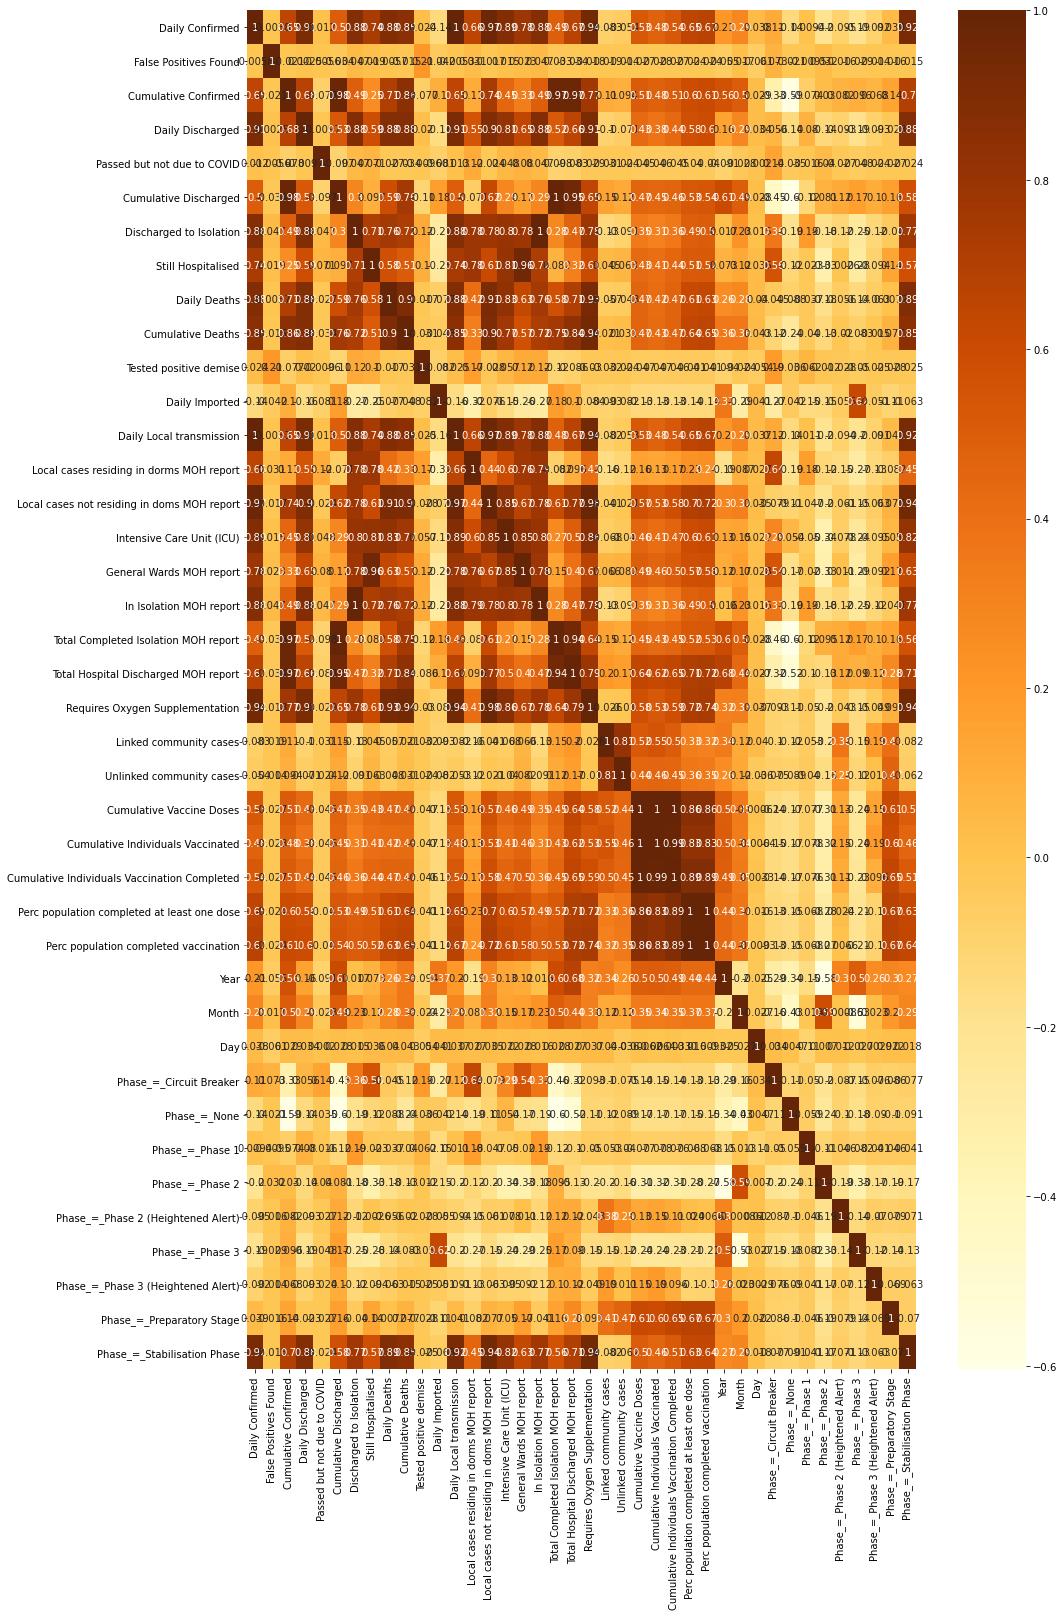

In [60]:
# corr. heatmap

plt.figure(figsize=(15,25))
sns.heatmap(sg_data_filtered.corr(), cmap='YlOrBr', annot=True)

In [61]:
# understanding correlation of all variables to imported cases (can change accordingly to the variable you are trying to predict)

sg_data_filtered.corr()["Intensive Care Unit (ICU)"].sort_values(ascending=False)

Intensive Care Unit (ICU)                       1.000000
Daily Local transmission                        0.887082
Daily Confirmed                                 0.886869
Requires Oxygen Supplementation                 0.858567
Local cases not residing in doms MOH report     0.850467
General Wards MOH report                        0.847596
Daily Deaths                                    0.827604
Phase_=_Stabilisation Phase                     0.817589
Daily Discharged                                0.813241
Still Hospitalised                              0.812244
In Isolation MOH report                         0.801300
Discharged to Isolation                         0.799585
Cumulative Deaths                               0.770946
Perc population completed vaccination           0.613693
Local cases residing in dorms MOH report        0.602324
Perc population completed at least one dose     0.598652
Total Hospital Discharged MOH report            0.496686
Cumulative Individuals Vaccinat

# Train Test Split

In [62]:
# change y variable accordingly to what is of interest

X = sg_data_filtered.drop("Intensive Care Unit (ICU)", axis=1)
y = sg_data_filtered["Intensive Care Unit (ICU)"]

In [63]:
# split using 20% for test as amount of data isn't much so that we've got more points to test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Linear Regression

In [64]:
# build multiple linear regression model

regression = LinearRegression()
regression.fit(X_train, y_train)
pred = regression.predict(X_test)

In [65]:
# assessing model

train_adjusted_r2 = 1 - (1-regression.score(X_train, y_train)) * (len(y)-1)/(len(y)-X.shape[1]-1)
test_adjusted_r2 = 1 - (1-regression.score(X_test, y_test)) * (len(y)-1)/(len(y)-X.shape[1]-1)
print("Evaluation Metrics for LR")
print(f"MAE: {mean_absolute_error(y_test, pred)}")
print(f"MSE: {mean_squared_error(y_test, pred)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, pred))}")
print(f"R-squared score for train: {regression.score(X_train, y_train)}")
print(f"Adjusted R-squared score for train: {train_adjusted_r2}")
print(f"R-squared score for test: {regression.score(X_test, y_test)}")
print(f"Adjusted R-squared score for test: {test_adjusted_r2}")
# print(f"Cross Validation Score: {round(np.mean(cross_val_score(regression, X, y, cv=5)), 4)}")
print(f"Cross Validation Score: {round(np.mean(cross_val_score(regression, X, y, cv=KFold(n_splits=5, shuffle=True, random_state=42))), 4)}")

Evaluation Metrics for LR
MAE: 2.1877507689190514
MSE: 13.677207989150237
RMSE: 3.698270945881364
R-squared score for train: 0.9638188036325206
Adjusted R-squared score for train: 0.9615093655665112
R-squared score for test: 0.9213975149151912
Adjusted R-squared score for test: 0.9163803350161608
Cross Validation Score: 0.9431


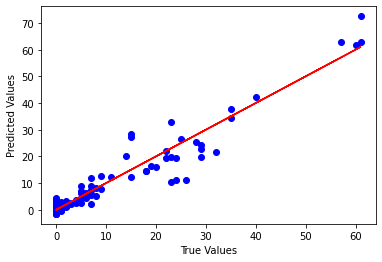

In [66]:
# For test set

# scatter for predictions
plt.scatter(y_test, pred, color = "blue")
# perfect predictions
plt.plot(y_test, y_test, color = "red")

plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.show()

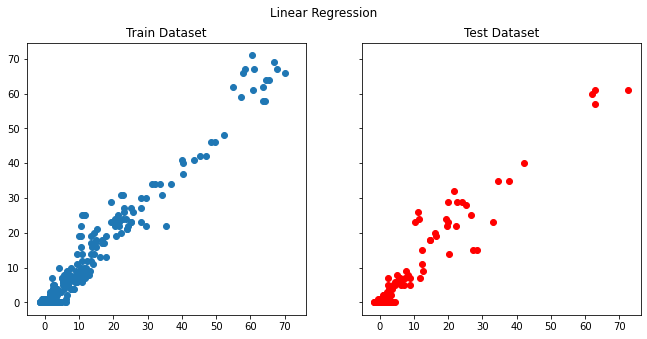

In [67]:
# visualise performance of train vs test

fig, ax = plt.subplots(1, 2, figsize=(11,5), sharey=True, sharex=True)

ax[0].scatter(regression.predict(X_train), y_train)
ax[1].scatter(pred, y_test, c = 'red')
ax[0].set_title('Train Dataset')
ax[1].set_title('Test Dataset')

plt.suptitle('Linear Regression')

plt.show()

In [68]:
# find out feature importance

regr_importance = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': regression.coef_
})

regr_importance = regr_importance.sort_values(by='Importance', ascending=False)
regr_importance

,Attribute,Importance
12,Daily Local transmission,3.922109e+07
11,Daily Imported,3.922109e+07
25,Perc population completed at least one dose,9.438564e+01
38,Phase_=_Stabilisation Phase,7.131310e+00
37,Phase_=_Preparatory Stage,3.319710e+00
30,Phase_=_Circuit Breaker,2.347739e+00
7,Still Hospitalised,1.877840e+00
6,Discharged to Isolation,1.876920e+00
9,Cumulative Deaths,1.820672e+00
5,Cumulative Discharged,1.769683e+00


# Ridge Regression

In [69]:
# build lasso model

ridge = Ridge()
ridge.fit(X_train, y_train)
ridge_pred = ridge.predict(X_test)

C:\Users\zeph1\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=8.02291e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


In [70]:
# assessing model

train_adjusted_r2 = 1 - (1-ridge.score(X_train, y_train)) * (len(y)-1)/(len(y)-X.shape[1]-1)
test_adjusted_r2 = 1 - (1-ridge.score(X_test, y_test)) * (len(y)-1)/(len(y)-X.shape[1]-1)
print("Evaluation Metrics for Ridge")
print(f"MAE: {mean_absolute_error(y_test, ridge_pred)}")
print(f"MSE: {mean_squared_error(y_test, ridge_pred)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, ridge_pred))}")
print(f"R-squared score for train: {ridge.score(X_train, y_train)}")
print(f"Adjusted R-squared score for train: {train_adjusted_r2}")
print(f"R-squared score for test: {ridge.score(X_test, y_test)}")
print(f"Adjusted R-squared score for test: {test_adjusted_r2}")
# print(f"Cross Validation Score: {round(np.mean(cross_val_score(ridge, X, y, cv=5)), 4)}")
print(f"Cross Validation Score: {round(np.mean(cross_val_score(ridge, X, y, cv=KFold(n_splits=5, shuffle=True, random_state=42))), 4)}")

Evaluation Metrics for Ridge
MAE: 2.1371900217930264
MSE: 13.435834613543108
RMSE: 3.6654924107878206
R-squared score for train: 0.9627321927146881
Adjusted R-squared score for train: 0.9603533965049874
R-squared score for test: 0.9227846801298373
Adjusted R-squared score for test: 0.9178560426913163
Cross Validation Score: 0.943


C:\Users\zeph1\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=8.02291e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\zeph1\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=8.46959e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\zeph1\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=8.67475e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\zeph1\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=8.39875e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\zeph1\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=8.02298e-17): result may not be accurate

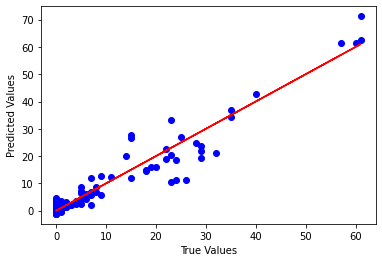

In [71]:
# For test set

# scatter for predictions
plt.scatter(y_test, ridge_pred, color = "blue")
# perfect predictions
plt.plot(y_test, y_test, color = "red")

plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.show()

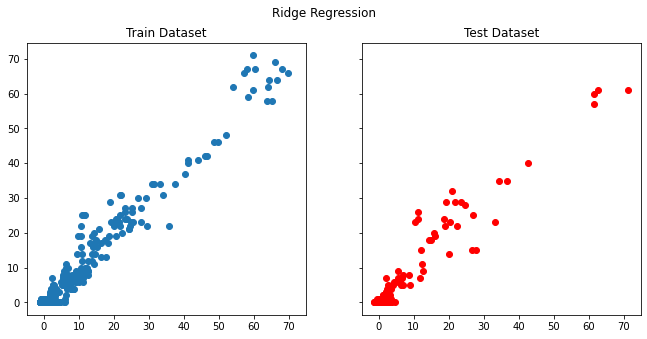

In [72]:
# visualise performance of train vs test

fig, ax = plt.subplots(1, 2, figsize=(11,5), sharey=True, sharex=True)

ax[0].scatter(ridge.predict(X_train), y_train)
ax[1].scatter(ridge_pred, y_test, c = 'red')
ax[0].set_title('Train Dataset')
ax[1].set_title('Test Dataset')

plt.suptitle('Ridge Regression')

plt.show()

In [73]:
# find out feature importance

ridge_importance = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': ridge.coef_
})

ridge_importance = ridge_importance.sort_values(by='Importance', ascending=False)
ridge_importance

,Attribute,Importance
25,Perc population completed at least one dose,3.592143
30,Phase_=_Circuit Breaker,3.413523
38,Phase_=_Stabilisation Phase,2.265128
26,Perc population completed vaccination,2.233181
7,Still Hospitalised,1.613466
6,Discharged to Isolation,1.612458
9,Cumulative Deaths,1.568765
5,Cumulative Discharged,1.509417
10,Tested positive demise,0.654954
4,Passed but not due to COVID,0.632286


# Important Features & Future Prediction

In [74]:
important_X = X[["Passed but not due to COVID","Tested positive demise","Cumulative Discharged","Cumulative Deaths","Discharged to Isolation","Still Hospitalised","Perc population completed vaccination","Perc population completed at least one dose","Year","Month","Day","Phase_=_Preparatory Stage","Phase_=_Phase 3 (Heightened Alert)","Phase_=_Phase 2","Phase_=_Stabilisation Phase","Phase_=_Phase 1","Phase_=_Phase 3","Phase_=_Phase 2 (Heightened Alert)","Phase_=_None","Phase_=_Circuit Breaker"]].copy()
important_X_train = X_train[["Passed but not due to COVID","Tested positive demise","Cumulative Discharged","Cumulative Deaths","Discharged to Isolation","Still Hospitalised","Perc population completed vaccination","Perc population completed at least one dose","Year","Month","Day","Phase_=_Preparatory Stage","Phase_=_Phase 3 (Heightened Alert)","Phase_=_Phase 2","Phase_=_Stabilisation Phase","Phase_=_Phase 1","Phase_=_Phase 3","Phase_=_Phase 2 (Heightened Alert)","Phase_=_None","Phase_=_Circuit Breaker"]].copy()
important_X_test = X_test[["Passed but not due to COVID","Tested positive demise","Cumulative Discharged","Cumulative Deaths","Discharged to Isolation","Still Hospitalised","Perc population completed vaccination","Perc population completed at least one dose","Year","Month","Day","Phase_=_Preparatory Stage","Phase_=_Phase 3 (Heightened Alert)","Phase_=_Phase 2","Phase_=_Stabilisation Phase","Phase_=_Phase 1","Phase_=_Phase 3","Phase_=_Phase 2 (Heightened Alert)","Phase_=_None","Phase_=_Circuit Breaker"]].copy()

In [75]:
# training the model based on the few features extracted
impt_ridge = Ridge()
impt_ridge.fit(important_X_train, y_train)
impt_ridge_pred = impt_ridge.predict(important_X_test)

In [76]:
# evaluating the new model with few select features
impt_train_adjusted_r2 = 1 - (1-impt_ridge.score(important_X_train, y_train)) * (len(y)-1)/(len(y)-important_X.shape[1]-1)
impt_test_adjusted_r2 = 1 - (1-impt_ridge.score(important_X_test, y_test)) * (len(y)-1)/(len(y)-important_X.shape[1]-1)
print("Evaluation Metrics for Ridge")
print(f"MAE: {mean_absolute_error(y_test, impt_ridge_pred)}")
print(f"MSE: {mean_squared_error(y_test, impt_ridge_pred)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, impt_ridge_pred))}")
print(f"R-squared score for train: {impt_ridge.score(important_X_train, y_train)}")
print(f"Adjusted R-squared score for train: {impt_train_adjusted_r2}")
print(f"R-squared score for test: {impt_ridge.score(important_X_test, y_test)}")
print(f"Adjusted R-squared score for test: {impt_test_adjusted_r2}")
# print(f"Cross Validation Score: {round(np.mean(cross_val_score(impt_ridge, important_X, y, cv=5)), 4)}")
print(f"Cross Validation Score: {round(np.mean(cross_val_score(impt_ridge, important_X, y, cv=KFold(n_splits=5, shuffle=True, random_state=42))), 4)}")

Evaluation Metrics for Ridge
MAE: 2.5297865168192355
MSE: 20.28600081187029
RMSE: 4.503998313928447
R-squared score for train: 0.9360952610782545
Adjusted R-squared score for train: 0.9340665392077229
R-squared score for test: 0.8834169899653239
Adjusted R-squared score for test: 0.8797159420277152
Cross Validation Score: 0.9163


# XGBoost

In [77]:
# XGBoost

xgb_param = XGBRegressor()
xgb_params = dict()
xgb_params["max_depth"] = [3, 4, 5, 8, 10]
xgb_params["subsample"] = [0.7, 0.8, 0.9]
xgb_params["colsample_bytree"] = [0.7, 0.8, 0.9]
xgb_params["min_child_weight"] = [2, 4, 6]

xgb_search = RandomizedSearchCV(xgb_param, xgb_params, n_jobs=-1, cv=KFold(n_splits=5, shuffle=True, random_state=42))
xgb_search.fit(important_X, y)
xgb_search.best_params_

{'subsample': 0.8,
 'min_child_weight': 4,
 'max_depth': 5,
 'colsample_bytree': 0.9}

In [78]:
xgb = XGBRegressor(learning_rate=0.03, n_estimators=300, subsample=0.8, max_depth=4, colsample_bytree=0.8, min_child_weight=4)
xgb.fit(important_X_train, y_train)
xgb_pred = xgb.predict(important_X_test)
train_adjusted_r2 = 1 - (1-xgb.score(important_X_train, y_train)) * (len(y)-1)/(len(y)-important_X.shape[1]-1)
test_adjusted_r2 = 1 - (1-xgb.score(important_X_test, y_test)) * (len(y)-1)/(len(y)-important_X.shape[1]-1)
print("Evaluation Metrics for XGBoost")
print(f"MAE: {mean_absolute_error(y_test, xgb_pred)}")
print(f"MSE: {mean_squared_error(y_test, xgb_pred)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, xgb_pred))}")
print(f"R-squared score for train: {xgb.score(important_X_train, y_train)}")
print(f"Adjusted R-squared score for train: {train_adjusted_r2}")
print(f"R-squared score for test: {xgb.score(important_X_test, y_test)}")
print(f"Adjusted R-squared score for test: {test_adjusted_r2}")
# print(f"Cross Validation Score: {round(np.mean(cross_val_score(xgb, important_X, y, cv=5)), 4)}")
print(f"Cross Validation Score: {round(np.mean(cross_val_score(xgb, important_X, y, cv=KFold(n_splits=5, shuffle=True, random_state=42))), 4)}")

Evaluation Metrics for XGBoost
MAE: 0.6976417016721409
MSE: 1.267218193247406
RMSE: 1.125707863189827
R-squared score for train: 0.9977256262085404
Adjusted R-squared score for train: 0.9976534238659545
R-squared score for test: 0.9927173368122395
Adjusted R-squared score for test: 0.9924861411554852
Cross Validation Score: 0.9915


# Prediction with XGBoost

In [121]:
future_prediction = pd.DataFrame(data={
    "Passed but not due to COVID":[0],
    "Tested positive demise":[0],
    "Cumulative Discharged":[500000],
    "Cumulative Deaths":[1200],
    "Discharged to Isolation":[90000],
    "Still Hospitalised":[3600],
    "Perc population completed vaccination":[90],
    "Perc population completed at least one dose":[91],
    "Year":[2021],
    "Month":[12],
    "Day":[14],
    "Phase_=_Preparatory Stage":[0],
    "Phase_=_Phase 3 (Heightened Alert)":[0],
    "Phase_=_Phase 2":[0],
    "Phase_=_Stabilisation Phase":[0],
    "Phase_=_Phase 1":[0],
    "Phase_=_Phase 3":[0],
    "Phase_=_Phase 2 (Heightened Alert)":[1],
    "Phase_=_None":[0],
    "Phase_=_Circuit Breaker":[0]
})

xgb_fut_pred = xgb.predict(future_prediction)
xgb_fut_pred

array([67.55383], dtype=float32)

In [80]:
xgb_fut_pred
# ICU occupancy at 64 on 14 Dec 2021

array([67.74779], dtype=float32)